In [51]:
import numpy as np
import pandas as pd

import cv2
import random
import os

# Визуализация
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# Тестови данни и крос-валидация
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict

# Анализ
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Модели за машино обучение
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Неврони мрежи
import tensorflow as tf
from tensorflow import keras

from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import SGD


### Анализ и обработка на данните

In [2]:
# 5 произволни изображения от данните
fig, axs = plt.subplots(1, 5, figsize=(300, 300))
path_tr = "/kaggle/input/asd-dataset-2/Asd_Dataset/"
fnames_list = os.listdir(path_tr)

for i in range(5):
    
    filename = random.choice(fnames_list)
    print(filename, end="\t")
    filename = path_tr + filename
    
    image = imread(filename)
    axs[i].imshow(image)

TS233_23.png	TC173_35.png	TC216_54.png	TS068_15.png	TC168_33.png	

In [3]:
def print_pie_chart_of_images(tc_len, ts_len, is_undersampled = False):
    if is_undersampled:
        print(f"Undersampled Non-ASD images count:{tc_len} and ASD images count:{ts_len}")
    else:
        print(f"Non-ASD images count:{tc_len} and ASD images count:{ts_len}")
    
    
    plt.figure(figsize=(5, 5))
    plt.pie(
        x = [tc_len, ts_len],
        labels = ['Non-ASD', 'ASD'],
        autopct = '%.2f',
    ) 
    if is_undersampled:
        plt.title("Undersampled Count of Non-ASD vs ASD images")    
    else:
        plt.title("Count of Non-ASD vs ASD images")
    
    plt.show()

Non-ASD images count:328 and ASD images count:220


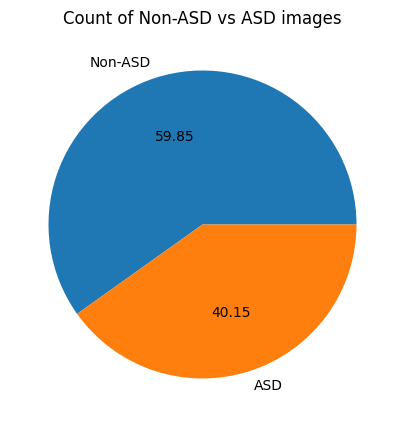

In [4]:
# Under-sampling не-РАС данни
fnames = np.array(os.listdir(path_tr))

tc_files = fnames[np.char.startswith(fnames, "TC")]
non_tc_files = fnames[~np.char.startswith(fnames, "TC")]
print_pie_chart_of_images(len(tc_files), len(non_tc_files))

Undersampled Non-ASD images count:220 and ASD images count:220


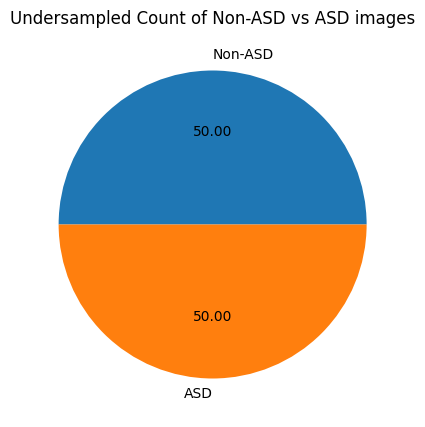

In [5]:
# Ensure equal count by slicing
tc_files = tc_files[:len(non_tc_files)]  

# Merge back
balanced_asd_files = np.concatenate([tc_files, non_tc_files])

print_pie_chart_of_images(
    len(balanced_asd_files[np.char.startswith(balanced_asd_files, "TC")]),
    len(balanced_asd_files[~np.char.startswith(balanced_asd_files, "TC")]),
    is_undersampled = True)

In [6]:
# Пре-аугментиране брой на снимките
print(f"Count of images pre-augmentation: {len(balanced_asd_files)}")

Count of images pre-augmentation: 440


In [7]:
# Аугментиране на снимките

augmenter = ImageDataGenerator(
    rotation_range=10,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

imgCount=5

In [8]:
augmented_dr = '/kaggle/working/Asd_Dataset_Augmented'
os.mkdir(augmented_dr)

In [9]:
# за всяко изображение се правят 5 аугментирани снимки

for fname in balanced_asd_files: # използване на undersampled-снимките

    if not fname.startswith("TC") and not fname.startswith("TS") :
        continue
    
    print("Current File:", fname)
    rel_path = os.path.join(path_tr, fname)
    img = load_img(rel_path)
    img = img_to_array(img)  # Numpy масив с размерност (3, 150, 150)
    img = img.reshape((1,) + img.shape)  # Numpy масив с размерност (1, 3, 150, 150)

    i = 0
    prefix = fname.split(".")[0]
    for batch in augmenter.flow(img, batch_size=1,
                              save_to_dir='Asd_Dataset_Augmented', save_prefix= f'{prefix}_Aug', save_format='png'):
        i += 1
        if i == imgCount:
            break

Current File: TC179_30.png
Current File: TC040_39.png
Current File: TC233_57.png
Current File: TC275_56.png
Current File: TC058_34.png
Current File: TC019_54.png
Current File: TC193_48.png
Current File: TC339_58.png
Current File: TC018_54.png
Current File: TC221_50.png
Current File: TC306_45.png
Current File: TC196_52.png
Current File: TC314_45.png
Current File: TC224_50.png
Current File: TC037_31.png
Current File: TC289_40.png
Current File: TC274_56.png
Current File: TC059_34.png
Current File: TC086_51.png
Current File: TC116_35.png
Current File: TC045_40.png
Current File: TC072_48.png
Current File: TC189_43.png
Current File: TC292_40.png
Current File: TC007_33.png
Current File: TC032_36.png
Current File: TC265_32.png
Current File: TC344_58.png
Current File: TC049_37.png
Current File: TC305_45.png
Current File: TC217_54.png
Current File: TC202_49.png
Current File: TC250_57.png
Current File: TC311_45.png
Current File: TC352_58.png
Current File: TC188_43.png
Current File: TC143_37.png
C

In [10]:
augmented_images = os.listdir(augmented_dr)
print(f"Count of augmented images: {len(augmented_images)}")

Count of augmented images: 2195


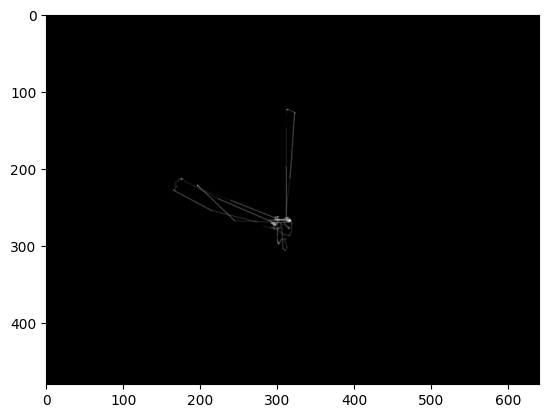

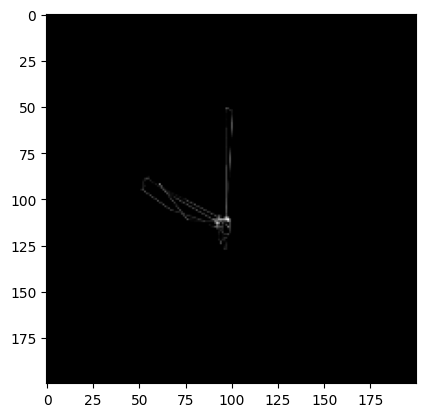

A TS (File: /kaggle/input/asd-dataset-2/Asd_Dataset/TS100_24.png) 

Original size: (480, 640)
Resized: (200, 200)


In [11]:
# Обработка на 1 произволна снимка
rand_file = random.choice(fnames_list)
rel_path = os.path.join(path_tr, rand_file)

img_as_array = cv2.imread(rel_path, cv2.IMREAD_GRAYSCALE)

resized_array = cv2.resize(img_as_array, dsize=(200, 200))

plt.imshow(img_as_array, cmap="gray")
plt.show()

plt.imshow(resized_array, cmap="gray")
plt.show()

img_class = rand_file[:2]
print("A {0} (File: {1}) \n".format(img_class, rel_path))
print("Original size: {}".format(img_as_array.shape))
print("Resized: {}".format(resized_array.shape))

In [12]:
get_img_class_fun = lambda category : int(category == 'TS')  # TS(asd) - 1, TC(Non-ASD) - 0

def load_preprocess(directory, size=100, is_test_set=False, to_grayscale=False, is_CNN_model=False):
    """ Read the entire corpus of images in the directory. 
    Convert them to grayscale and normalize their size. 
    Determine the Explained variables in function of the filename. 
    Return all the Explanatory and Explained variables (dictionary of lists). 
    """
    
    EXPLANATORY = []
    EXPLAINED = []
    ids = [] 
    
    # Iterate over files
    for fname in os.listdir(directory):
        
        if is_test_set:
            # Създава списък за тестови данни с id-та имената на файлове 
            img_id = int(fname.split(".")[0].split("_")[-1])
            ids.append(img_id)
        else:
            # Format: "[TC|TS]XXXX_XX.jpg" ASD or non ASd
            img_class = fname[:2]
            img_class_num = get_img_class_fun(img_class)
        
        rel_path = os.path.join(directory, fname)
        
        n_colors = 3
        if to_grayscale:
            n_colors = 1
            img_as_array = cv2.imread(rel_path, cv2.IMREAD_GRAYSCALE)   # Read as grayscale
        else: 
            img_as_array = cv2.imread(rel_path) 
            
        resized_array = cv2.resize(img_as_array, dsize=(size, size))
        
        EXPLANATORY.append(resized_array)
        if not is_test_set:
            EXPLAINED.append(img_class_num) # id на дали е клас или не
        
    # np.reshape: Gives a new shape to an array without changing its data.
    if is_CNN_model:
        EXPLANATORY = np.array(EXPLANATORY).reshape(-1, size, size, n_colors)
    else:
        EXPLANATORY = np.array(EXPLANATORY).reshape(-1, (size * size), n_colors) # flatten
    
    EXPLAINED = np.array(EXPLAINED)
    EXPLANATORY = EXPLANATORY / 255.0  # because color codes in [0, 255]
    
    return {"EXPLANATORY":EXPLANATORY, "EXPLAINED":EXPLAINED, "IDS":ids}

In [13]:
#######################################################################
# Read the training set and apply transformations
TR_SET = load_preprocess(augmented_dr, to_grayscale = True, size=200)
#######################################################################

In [14]:
print(TR_SET["EXPLANATORY"].shape)
print(TR_SET["EXPLAINED"].shape)
print(len(TR_SET["IDS"]))  # must be 0 when loading the Training set

(2195, 40000, 1)
(2195,)
0


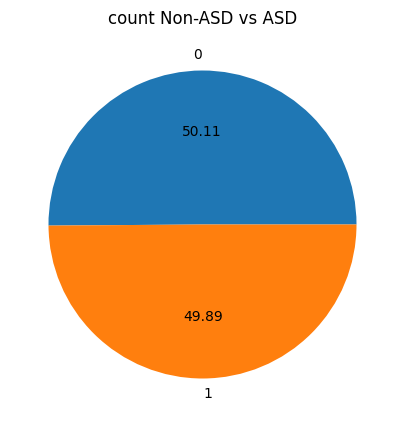

In [15]:
df_class = pd.Series(TR_SET["EXPLAINED"])
plt.figure(figsize=(5, 5))
plt.pie(
    x = df_class.value_counts(),
    labels = ['0', '1'],
    autopct = '%.2f',
) 
plt.title("count Non-ASD vs ASD")
plt.show()

In [16]:
print("Mean:", np.mean(TR_SET["EXPLANATORY"]))
print("Median:", np.median(TR_SET["EXPLANATORY"]))
print("Min:", np.min(TR_SET["EXPLANATORY"]))
print("Max:", np.max(TR_SET["EXPLANATORY"]))

Mean: 0.0037853158247353603
Median: 0.0
Min: 0.0
Max: 0.9098039215686274


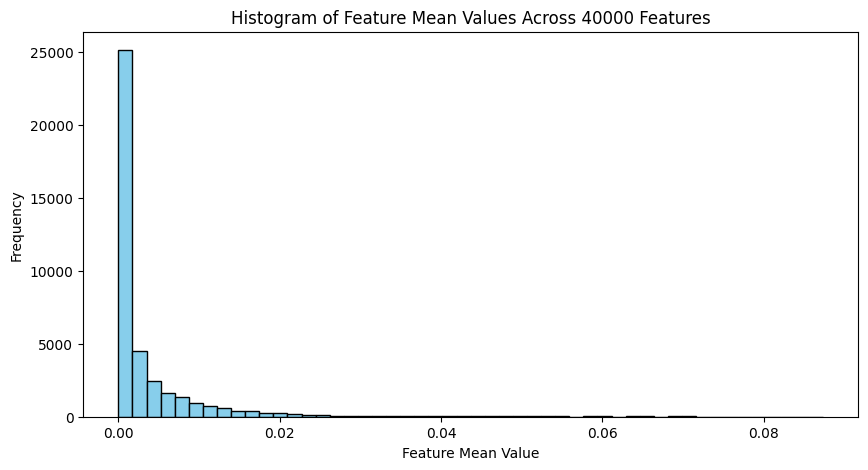

In [17]:
# heatmap
arr = TR_SET["EXPLANATORY"].reshape(TR_SET["EXPLANATORY"].shape[0], -1)  # Shape: (2193, 40000)

# Compute mean value for each feature across all samples
feature_means = np.mean(arr, axis=0)  # Shape: (40000,)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(feature_means, bins=50, color="skyblue", edgecolor="black")  # Adjust bins as needed
plt.xlabel("Feature Mean Value")
plt.ylabel("Frequency")
plt.title("Histogram of Feature Mean Values Across 40000 Features")
plt.show()

(1100,)
(1095,)


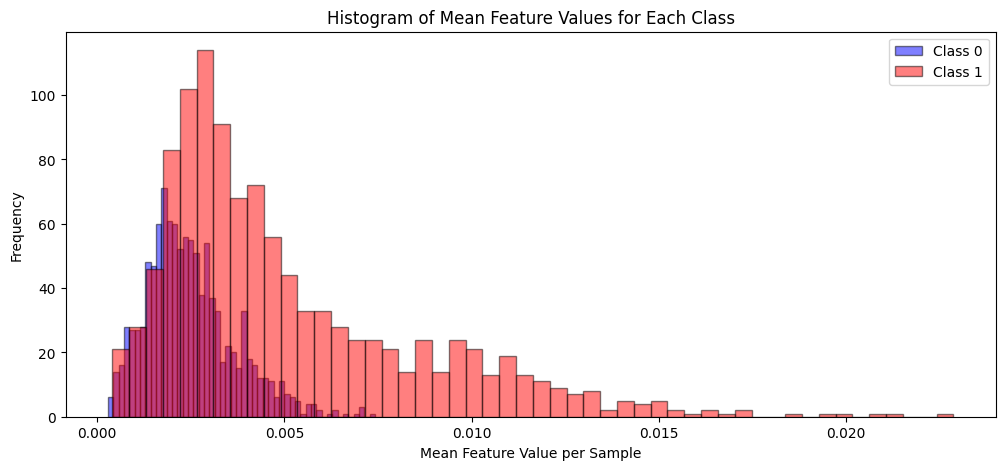

In [18]:
mean_features_class_0 = np.mean(arr[TR_SET["EXPLAINED"] == 0], axis=1).flatten()
mean_features_class_1 = np.mean(arr[TR_SET["EXPLAINED"] == 1], axis=1).flatten()

print(mean_features_class_0.shape)
print(mean_features_class_1.shape)
# Plot histograms
plt.figure(figsize=(12, 5))

plt.hist(mean_features_class_0, bins=50, alpha=0.5, label="Class 0", color="blue", edgecolor="black")
plt.hist(mean_features_class_1, bins=50, alpha=0.5, label="Class 1", color="red", edgecolor="black")

plt.xlabel("Mean Feature Value per Sample")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Feature Values for Each Class")
plt.legend()
plt.show()

In [39]:
def alarms(cm):
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)

    print("#####   Alarms   ##### \n")
    print(f"True Positive Rate: {TPR:.2f}")
    print(f"False Positive Rate: {FPR:.2f}")
    
    print(f"True Negative Rate: {TNR:.2f}")
    print(f"False Negative Rate: {FNR:.2f}")

In [40]:
def create_conf_matrix(actual, predicted, attack):
    
    conf_matrix = confusion_matrix(actual, predicted)
    print("Confusion matrix: \n{}".format(conf_matrix))

    ACC = classification_report(actual, predicted, output_dict=True)['accuracy']
    print("\n#####   Accuracy: {} %   ##### \n\n\n".format(ACC*100))

    # Get all stats
    print(classification_report(actual, predicted, output_dict=False))
    
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g' )
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(f"Confusion Matrix - {attack}")
    plt.show()
    alarms(conf_matrix)
    return conf_matrix

In [20]:
X = TR_SET["EXPLANATORY"].reshape(TR_SET["EXPLANATORY"].shape[0], 40000)
y = TR_SET["EXPLAINED"]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Наивен бейсов класификатор

In [21]:
naive_bayes = GaussianNB()
nb_results = cross_validate(naive_bayes, X, y, cv=kf, scoring='accuracy', return_train_score=True)
nb_results

{'fit_time': array([1.18505335, 1.18672276, 1.18976855, 1.18976021, 1.20904589,
        1.20239472, 1.18861294, 1.18273687, 1.21855044, 1.19222093]),
 'score_time': array([0.09285641, 0.08482146, 0.08675909, 0.08664608, 0.08718204,
        0.09438968, 0.08415675, 0.08522344, 0.09024882, 0.08409595]),
 'test_score': array([0.60454545, 0.73636364, 0.71363636, 0.68636364, 0.71363636,
        0.62100457, 0.66210046, 0.69863014, 0.70319635, 0.73515982]),
 'train_score': array([0.8243038 , 0.81164557, 0.81417722, 0.82025316, 0.81974684,
        0.82135628, 0.8208502 , 0.81629555, 0.81325911, 0.81680162])}

In [ ]:
nb_cross_predict = cross_val_predict(naive_bayes, X, y,  cv = kf)

Confusion matrix: 
[[812 288]
 [398 697]]

#####   Accuracy: 68.74715261958998 %   ##### 



              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1100
           1       0.71      0.64      0.67      1095

    accuracy                           0.69      2195
   macro avg       0.69      0.69      0.69      2195
weighted avg       0.69      0.69      0.69      2195



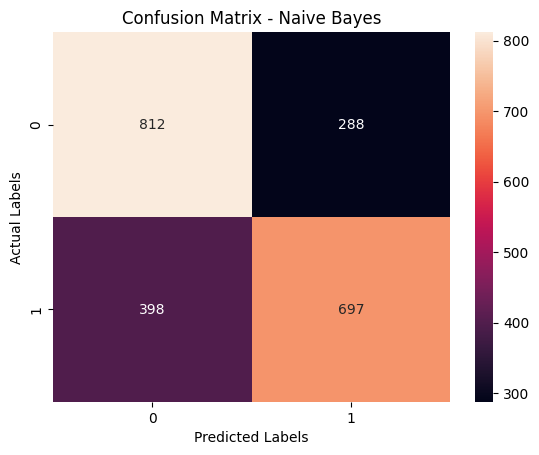

#####   Alarms   ##### 

True Positive Rate: 0.64
False Positive Rate: 0.26
True Negative Rate: 0.74
False Negative Rate: 0.36


In [41]:
nb_conf_matrix = create_conf_matrix(y, nb_cross_predict, "Naive Bayes")

In [23]:
# стойности за срванение с Random Forest
nb_accuracy = cross_val_score(naive_bayes, X, y, cv=kf, scoring='accuracy')
nb_precision = cross_val_score(naive_bayes, X, y, cv=kf, scoring='precision')
nb_recall = cross_val_score(naive_bayes, X, y, cv=kf, scoring='recall')

print(f"{nb_accuracy.mean()}, {min(nb_accuracy)}, {max(nb_accuracy)}, {nb_accuracy.std()}")
# за сранява между трите модела min|max|mean|standart deviation|name 

0.6874636778746368, 0.6045454545454545, 0.7363636363636363, 0.042831182187868196


## Random forrest

In [24]:
random_forrest = RandomForestClassifier(n_estimators=50)
rf_results = cross_validate(random_forrest, X, y, cv=kf, scoring='accuracy', return_train_score=True)
rf_results

{'fit_time': array([6.36938953, 6.19999456, 6.31019545, 6.48902726, 6.00348544,
        6.50719047, 6.29061151, 6.17716527, 6.10955834, 6.16544724]),
 'score_time': array([0.02176905, 0.02153516, 0.02099013, 0.02088523, 0.02053881,
        0.02118468, 0.02074695, 0.02213335, 0.02075934, 0.02048683]),
 'test_score': array([0.67272727, 0.79090909, 0.74545455, 0.76363636, 0.73636364,
        0.73972603, 0.73515982, 0.73059361, 0.70776256, 0.71689498]),
 'train_score': array([1.        , 1.        , 1.        , 0.99898734, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ])}

In [ ]:
rf_cross_predict = cross_val_predict(random_forrest, X, y,  cv = kf)

Confusion matrix: 
[[813 287]
 [307 788]]

#####   Accuracy: 72.9384965831435 %   ##### 



              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1100
           1       0.73      0.72      0.73      1095

    accuracy                           0.73      2195
   macro avg       0.73      0.73      0.73      2195
weighted avg       0.73      0.73      0.73      2195



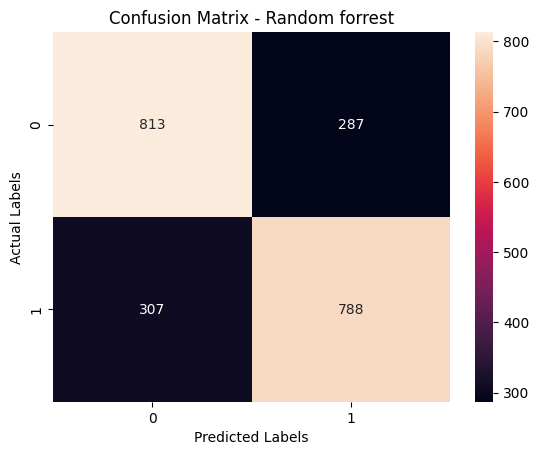

#####   Alarms   ##### 

True Positive Rate: 0.72
False Positive Rate: 0.26
True Negative Rate: 0.74
False Negative Rate: 0.28


In [42]:
rf_conf_matrix = create_conf_matrix(y, rf_cross_predict, "Random forrest")

In [26]:
rf_accuracy = cross_val_score(random_forrest, X, y, cv=kf, scoring='accuracy')
rf_precision = cross_val_score(random_forrest, X, y, cv=kf, scoring='precision')
rf_recall = cross_val_score(random_forrest, X, y, cv=kf, scoring='recall')
print(f"{rf_accuracy.mean()}, {min(rf_accuracy)}, {max(rf_accuracy)}, {rf_accuracy.std()}")
# сранява между двата модела min|max|mean|standart deviation|name 

0.7316438356164383, 0.684931506849315, 0.7636363636363637, 0.025755179314048606


Text(0.5, 1.0, "Comparison between the model's confusion matrixes")

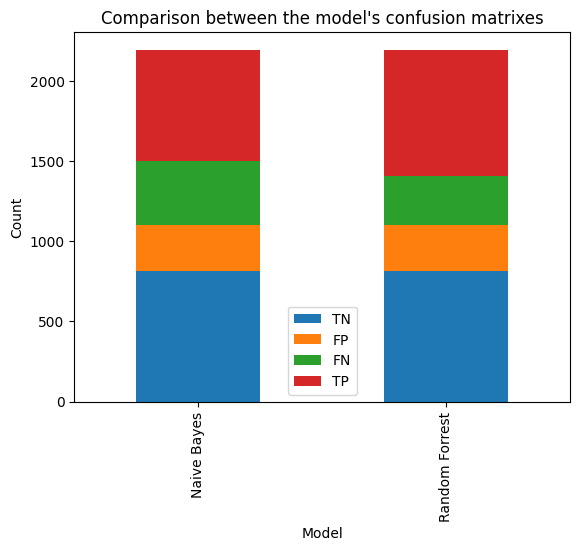

In [36]:
# Сравнение на резултатите
nb_ravel = nb_conf_matrix.ravel()
rf_ravel = rf_conf_matrix.ravel()

conf_matrix_df = pd.DataFrame({'TN': [nb_ravel[0], rf_ravel[0]],
                   'FP': [nb_ravel[1], rf_ravel[1]],
                   'FN': [nb_ravel[2], rf_ravel[2]],
                  'TP': [nb_ravel[3], rf_ravel[3]]},
                  index=['Naive Bayes', 'Random Forrest'])

conf_matrix_df.plot(kind='bar', stacked=True)

plt.xlabel('Model')
plt.ylabel('Count')

plt.title("Comparison between the model's confusion matrixes")

In [37]:
# Classification metrics сравнения
print("####### Accuracy comparison #######")
accuracy_df = pd.DataFrame({'mean': [nb_accuracy.mean(), rf_accuracy.mean()],
                   'min': [min(nb_accuracy), min(rf_accuracy)],
                   'max': [max(nb_accuracy), max(rf_accuracy)],
                   'standart_deviation': [nb_accuracy.std(), rf_accuracy.std()],
                   'Model': ['Naive Bayes', 'Random Forrest']})
print(accuracy_df)

print()
print("####### Precision comparison #######")
precision_df = pd.DataFrame({'mean': [nb_precision.mean(), rf_precision.mean()],
                   'min': [min(nb_precision), min(rf_precision)],
                   'max': [max(nb_precision), max(rf_precision)],
                   'standart_deviation': [nb_precision.std(), rf_precision.std()],
                   'Model': ['Naive Bayes', 'Random Forrest']})
print(precision_df)

print()
print("####### Recall comparison #######")
precision_df = pd.DataFrame({'mean': [nb_recall.mean(), rf_recall.mean()],
                   'min': [min(nb_recall),min(rf_recall)],
                   'max': [max(nb_recall), max(rf_recall)],
                   'standart_deviation': [nb_recall.std(), rf_recall.std()],
                   'Model': ['Naive Bayes', 'Random Forrest']})
print(precision_df)

####### Accuracy comparison #######
       mean       min       max  standart_deviation           Model
0  0.687464  0.604545  0.736364            0.042831     Naive Bayes
1  0.731644  0.684932  0.763636            0.025755  Random Forrest

####### Precision comparison #######
       mean       min       max  standart_deviation           Model
0  0.707312  0.556701  0.766990            0.057481     Naive Bayes
1  0.738765  0.645161  0.809524            0.049053  Random Forrest

####### Recall comparison #######
       mean       min       max  standart_deviation           Model
0  0.635444  0.551020  0.699115            0.048290     Naive Bayes
1  0.720816  0.591837  0.825688            0.057163  Random Forrest


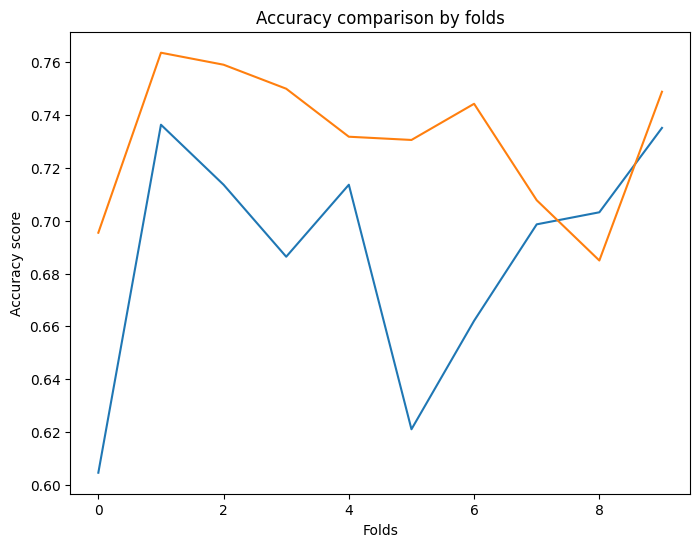

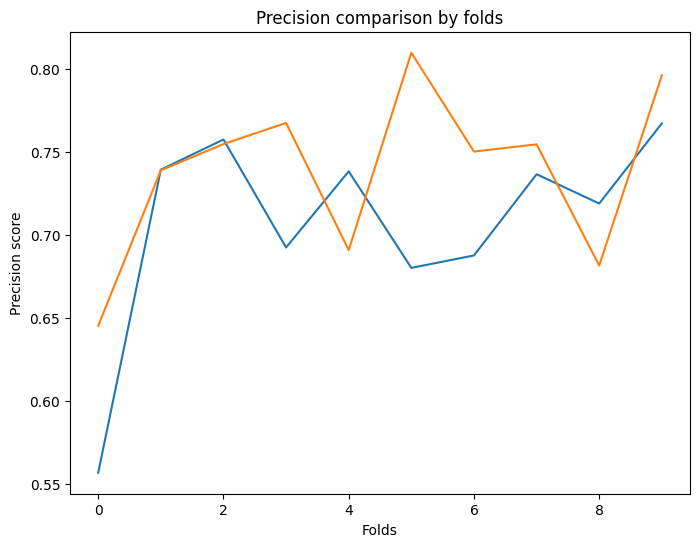

<Figure size 640x480 with 0 Axes>

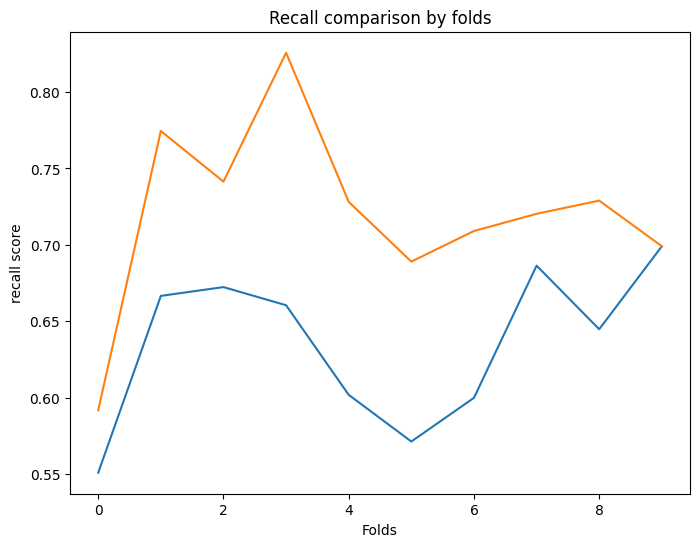

In [38]:
plt.subplots(figsize=(8, 6))
plt.plot(nb_accuracy, label="Naive Bayes")
plt.plot(rf_accuracy, label ="Random Forrest")
plt.title("Accuracy comparison by folds")
plt.xlabel('Folds')
plt.ylabel('Accuracy score')
plt.show()

plt.subplots(figsize=(8, 6))
plt.plot(nb_precision, label="Naive Bayes")
plt.plot(rf_precision, label ="Random Forrest")
plt.title("Precision comparison by folds")
plt.xlabel('Folds')
plt.ylabel('Precision score')
plt.show()

plt.tight_layout()
plt.subplots(figsize=(8, 6))
plt.plot(nb_recall, label="Naive Bayes")
plt.plot(rf_recall, label ="Random Forrest")
plt.title("Recall comparison by folds")
plt.xlabel('Folds')
plt.ylabel('recall score')
plt.show()

## Невронни мрежи

In [27]:
def model_factory_VGG():
    
    # Instantiate the pre-trained VGG-16 model from keras.applications
    # In order for the VGG-16 model to work correctly, the input_shape 
    # must be (224, 224, 3) i.e. 224x224 pixels and 3 colors. 
    # This is because the VGG-16 model was pre-trained on ImageNet and 
    # configured to expect exactly this input format. 
    # The argument include_top=False removes the classifier part of the model. 
    model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
    
    # Use the loaded model without training/changing the weights of the existing layers
    for layer in model_vgg16.layers[:10]:
        layer.trainable = False
    
    # Add few supplementary layers
    # Flatten: Flattens the input. Does not affect the batch size.
    flatten_ly = Flatten()(model_vgg16.layers[-1].output) # add a Flatten layer
    
    flatten_ly = Dropout(0.4)(flatten_ly)
    # clasifier layer
    
    classif_ly = Dense(256, activation='relu', kernel_initializer='he_uniform')(flatten_ly) 
    
    # Output layer with a sigmoid activation function 
    output_ly = Dense(1, activation='sigmoid')(classif_ly)
    
    model = Model(inputs=model_vgg16.inputs, outputs=output_ly)
    
    # Use Stochastic Gradient Descent as optimizer
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [28]:
TR_SET = load_preprocess(augmented_dr, 224, to_grayscale=False, is_CNN_model = True)

In [29]:
print(TR_SET["EXPLANATORY"].shape)
print(TR_SET["EXPLAINED"].shape)
print(len(TR_SET["IDS"]))

(2195, 224, 224, 3)
(2195,)
0


In [30]:
enhanced_model = model_factory_VGG()

X_train, X_test, y_train, y_test = train_test_split(TR_SET["EXPLANATORY"], TR_SET["EXPLAINED"], test_size=0.2, random_state=42)

enhanced_model_fit = enhanced_model.fit(X_train, 
                                        y_train, 
                                        epochs=10, 
                                        batch_size=32, 
                                        validation_split=0.2)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.5584 - loss: 0.7004 - val_accuracy: 0.7301 - val_loss: 0.5446
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.7108 - loss: 0.5530 - val_accuracy: 0.7614 - val_loss: 0.4709
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.7463 - loss: 0.4827 - val_accuracy: 0.7273 - val_loss: 0.5352
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.7636 - loss: 0.4622 - val_accuracy: 0.7642 - val_loss: 0.4408
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.7725 - loss: 0.4549 - val_accuracy: 0.7670 - val_loss: 0.4572
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - accuracy: 0.8328 - loss: 0.3415 - val_accuracy: 0.8466 - val_loss: 0.3484
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.8689 - loss: 0.2945 - val_accuracy: 0.8153 - val_loss: 0.3323
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 288m

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


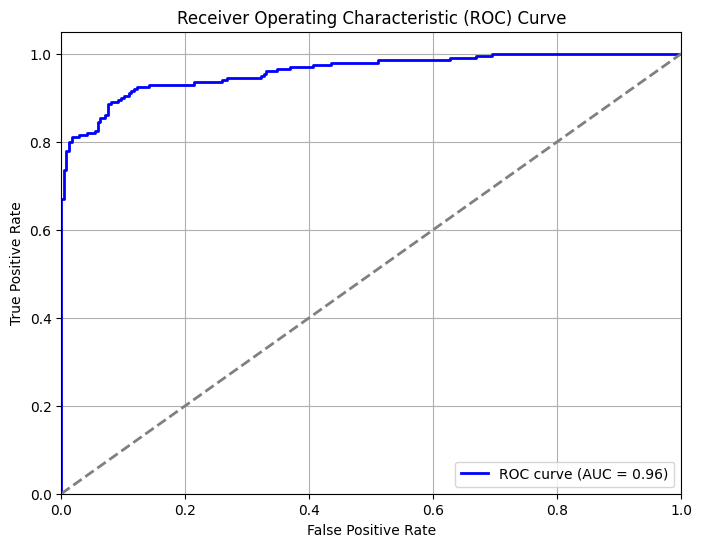

ROC AUC Score: 0.96


In [35]:
y_pred_prob = enhanced_model.predict(X_test)  # This will give probabilities between 0 and 1

# Step 4: Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Step 5: Compute the AUC scorew
roc_auc = auc(fpr, tpr)

# Step 6: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Optionally: Print the AUC score
print(f'ROC AUC Score: {roc_auc:.2f}')